

##  Neural Network From Scratch

Build a two-layer neural network from scratch In python.

Description : To gain a better understanding of Deep Learning, build a Neural
Network from scratch using only python, without a deep learning library like
TensorFlow. Understanding the inner workings of a Neural Network is important to
a ML Engineer.

http://yann.lecun.com/exdb/mnist/

In [ ]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from math import sqrt
import os
from sklearn import metrics
import seaborn
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

In [ ]:
class MNIST_data():

  def read_images(self, address, num_images ): 
    _im_size = 28
    f = gzip.open(address, 'r')
    f.read(16)
    buffer = f.read(_im_size * _im_size * num_images)
    data = np.frombuffer(buffer, dtype = np.uint8).astype(np.float32)
    data = data.reshape(num_images,_im_size, _im_size)

    return data/256.0

  def read_labels(self, address, num_images): 
    f = gzip.open(address, 'r')
    f.read(8)
    buffer = f.read(num_images)
    labels = np.frombuffer(buffer, dtype = np.uint8).astype(np.int64)
    
    return labels

  def read_data(self):

    X_test = self.read_images('t10k-images-idx3-ubyte.gz', 10000 ) 
    y_test = self.read_labels('t10k-labels-idx1-ubyte.gz', 10000 )    
    X_train = self.read_images('train-images-idx3-ubyte.gz', 60000) 
    y_train = self.read_labels('train-labels-idx1-ubyte.gz', 60000)

    print("X_test -> ",X_test.shape, X_test.dtype)
    print("y_test -> ",y_test.shape, y_test.dtype)
    print("X_train -> ",X_train.shape, X_train.dtype)
    print("y_train -> ", y_train.shape, y_train.dtype)

    self.show_images(X_train, y_train, "Train")
    self.show_images(X_test, y_test, "Test")

    return X_train, y_train, X_test, y_test

  def show_images(self,X, y, title):
    _ , axes = plt.subplots(2,10,figsize=(15,3), dpi = 80)
    
    p = 0
    arr = np.arange(X.shape[0])
    loc = np.random.choice(arr,size = 20, replace=False)

    for i in range(2):
      for j in range(10):
        axes[i,j].imshow(X[loc[p]])
        axes[i,j].set_title("{} ({}) ".format(y[loc[p]], title) ,fontsize = 12)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        p +=1
    plt.plot()


def reshape_data(X_train, y_train, X_test, y_test ):
  X_train = X_train.reshape(-1, 28*28)
  X_test = X_test.reshape(-1, 28*28)

  y_train = OneHotEncoder().fit_transform(y_train[:,np.newaxis]).toarray()
  y_test = OneHotEncoder().fit_transform(y_test[:,np.newaxis]).toarray()

  print(X_train.shape)
  print(y_train.shape)
  print(X_test.shape)
  print(y_test.shape)

  return X_train, y_train, X_test, y_test 

def plot_summary(loss, lr, str_ = "Loss"):
  train_loss = loss[0]
  val_loss = loss[1]
  figure, axis = plt.subplots(1,1, figsize=(12,6 ), dpi=80)
  axis.plot(train_loss, c= 'b', label ='Training_' + str_)
  axis.plot(val_loss, c= 'r', label ='Validation_' + str_)
  axis.set_title(str_ + '_ plot for Learning rate = {}'.format(lr))
  axis.set_xlabel('Epoch')
  axis.set_ylabel(str_ )
  axis.legend()
  plt.show()

MNIST has a training set of 60,000 examples, and a test set of 10,000 examples.

X_test ->  (10000, 28, 28) float32
y_test ->  (10000,) int64
X_train ->  (60000, 28, 28) float32
y_train ->  (60000,) int64
(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


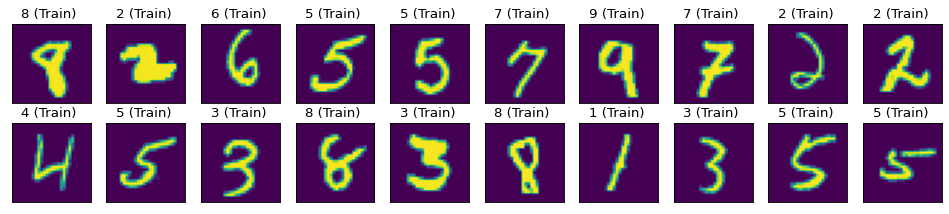

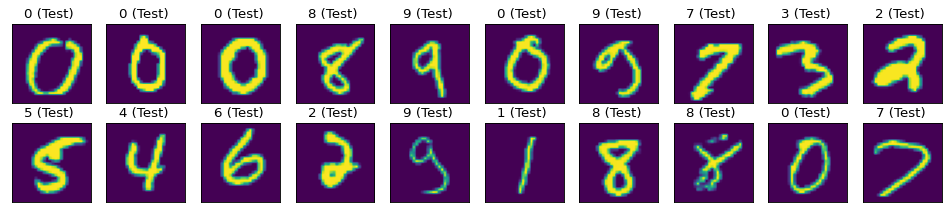

In [ ]:
loader = MNIST_data()
X_train, y_train, X_test, y_test = loader.read_data()
X_train, y_train, X_test, y_test  = reshape_data(X_train, y_train, X_test, y_test)

In [ ]:
class NeuralNetwork():

  def __init__(self, layer_sizes):
    self.layer_sizes = layer_sizes

    # Xavier Weight Initialization
    self.lower, self.upper = -(1.0 / sqrt(self.layer_sizes[0])), (1.0 / sqrt(self.layer_sizes[0]))
    self.W1 = self.lower + (self.upper - self.lower)*np.random.rand(self.layer_sizes[0],self.layer_sizes[1])

    # Xavier Weight Initialization
    self.lower, self.upper = -(1.0 / sqrt(self.layer_sizes[1])), (1.0 / sqrt(self.layer_sizes[1]))
    self.W2 = self.lower + (self.upper - self.lower)* np.random.rand(self.layer_sizes[1],self.layer_sizes[2])

    self.Z1 = None
    self.Z2 = None
    self.A1 = None
    self.A2 = None
    self.X = None
    
    self.s1 = None
    self.s2 = None


    self.dl_dW1 = None
    self.dl_dW2 =  None

    self.train_loss = []
    self.val_loss = []
    self.accuracy_train = []
    self.accuracy_val = []

    self.X_train = None
    self.X_test = None
    self.y_train = None
    self.y_test = None

    self.batch_size = None

  def load_data(self,train_x,train_y,test_x,test_y,batch_size = 32):
    self.X_train = train_x
    self.X_test = test_x
    self.y_train = train_y
    self.y_test = test_y

    self.batch_size = batch_size
  
  def softmax(self, h):
    e_x = np.exp(h)
    return e_x / (np.sum(e_x, axis = 1)[:,np.newaxis])

  def del_sigmoid(self, h):
    return np.multiply(self.sigmoid(h),( 1 - self.sigmoid(h)))
  
  def sigmoid(self, h):
    n = 1
    d = (1 + np.exp(-h))
    y = n / d 
    return y
    
  def compute_cross_entropy_loss(self,h,y):
    m = y.shape[0]
    error = -np.sum(np.multiply(y, np.log(h)))
    return (1/m)*error

  def compute_forward_pass(self, X):

    self.X = X
    self.Z1 = np.dot(self.X,self.W1)
    self.A1 = self.sigmoid(self.Z1)

    self.Z2 = np.dot(self.A1,self.W2)
    self.A2 = self.softmax(self.Z2)
    return self.A2
    
  def back_propogation(self , h , y):
    
    m = h.shape[0]

    dl_dz2 = h - y      
    dz2_dw2 = self.A1    
    self.dl_dW2 = np.dot(dz2_dw2.T, dl_dz2)

    dz2_da1 = np.dot(dl_dz2, (self.W2).T)
    da1_dz1 = self.del_sigmoid(self.Z1) 
    
    dl_dz1 = np.multiply( da1_dz1, dz2_da1)
    dz1_dw1 = self.X
    self.dl_dW1 = np.dot(dz1_dw1.T, dl_dz1)
    
  def update_grad(self, lr):

    # RMS_PROP
    beta= 0.9
    epi = 0.000000001

    self.s1 = beta*self.s1 + (1-beta)*np.multiply(self.dl_dW1, self.dl_dW1)
    s1 = 1/np.sqrt(self.s1 + epi)
    self.W1 = self.W1 - lr*np.multiply(self.dl_dW1 ,s1)

    self.s2 = beta*self.s2 + (1-beta)*np.multiply(self.dl_dW2, self.dl_dW2)
    s2 =1/ np.sqrt(self.s2 + epi)

    self.W2 = self.W2 - lr*np.multiply(self.dl_dW2 ,s2)


  def gradient_descent(self, lr = 1, n_epochs = 100):
  
    n_batches = self.X_train.shape[0]//self.batch_size

    for epoch in range(n_epochs): 
      
      X_train, y_train = shuffle(self.X_train, self.y_train, random_state=epoch + 1)
      batch_X = X_train[0:n_batches*self.batch_size].reshape(-1, 32,28*28)
      batch_y = y_train[0:n_batches*self.batch_size].reshape(-1, 32, 10)

      self.s1 = 0
      self.s2 = 0
      # self.m1 = 0
      # self.m2 = 0
      self.dl_dW1 = 0
      self.dl_dW2 = 0

      for i in range(batch_X.shape[0]):

        train_x = batch_X[i]
        train_y = batch_y[i]

        h = self.compute_forward_pass(train_x)
        j = self.compute_cross_entropy_loss(h, train_y)

        self.back_propogation(h,train_y)

        # EXponential Decaying Learning rate Scheduling
        l = lr*(0.1**(epoch/n_epochs))
        self.update_grad(l)


      h_train = self.compute_forward_pass(self.X_train)
      j_train = self.compute_cross_entropy_loss(h_train, self.y_train) 
      
      h_val = self.compute_forward_pass(self.X_test)  
      j_val = self.compute_cross_entropy_loss(h_val, self.y_test)
      
      accuracy_tr = accuracy_score(
        np.argmax(self.y_train, axis = 1), 
        np.argmax(h_train, axis = 1))
      
      accuracy_va = accuracy_score(
        np.argmax(self.y_test, axis = 1),  
        np.argmax(h_val, axis = 1))

      self.train_loss.append(np.sum(j_train)) 
      self.accuracy_train.append(accuracy_tr)
      self.val_loss.append(np.sum(j_val))  
      self.accuracy_val.append(accuracy_va)
      
      print("{} --  LR: {} TrainLoss: {}  ValLoss: {}  TrainAcc: {}  ValAcc: {}".format(
        epoch,l, np.sum(j_train),np.sum(j_val),accuracy_tr,accuracy_va   
    ))
      
    return self.train_loss, self.val_loss

 
 N Hidden =  16
0 --  LR: 0.01 TrainLoss: 0.24593810386339893  ValLoss: 0.2619482837709442  TrainAcc: 0.9271666666666667  ValAcc: 0.9215
1 --  LR: 0.008254041852680184 TrainLoss: 0.20303648717817824  ValLoss: 0.2228020698400651  TrainAcc: 0.9408  ValAcc: 0.9362
2 --  LR: 0.0068129206905796135 TrainLoss: 0.18203747660220387  ValLoss: 0.20486512680880065  TrainAcc: 0.9486666666666667  ValAcc: 0.9437
3 --  LR: 0.005623413251903491 TrainLoss: 0.17823212403738747  ValLoss: 0.2086370267160908  TrainAcc: 0.9502166666666667  ValAcc: 0.9433
4 --  LR: 0.004641588833612779 TrainLoss: 0.17579921253540154  ValLoss: 0.2122417480044605  TrainAcc: 0.9502833333333334  ValAcc: 0.9421
5 --  LR: 0.0038311868495572877 TrainLoss: 0.1557168290028812  ValLoss: 0.19895158053574993  TrainAcc: 0.9570833333333333  ValAcc: 0.9461
6 --  LR: 0.0031622776601683794 TrainLoss: 0.15425139256013065  ValLoss: 0.20206123373476548  TrainAcc: 0.9573333333333334  ValAcc: 0.9452
7 --  LR: 0.0026101572156825366 TrainLoss: 0.1

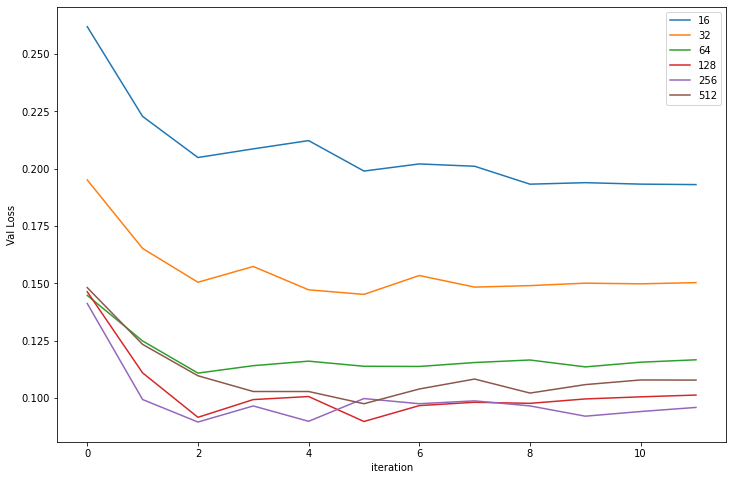

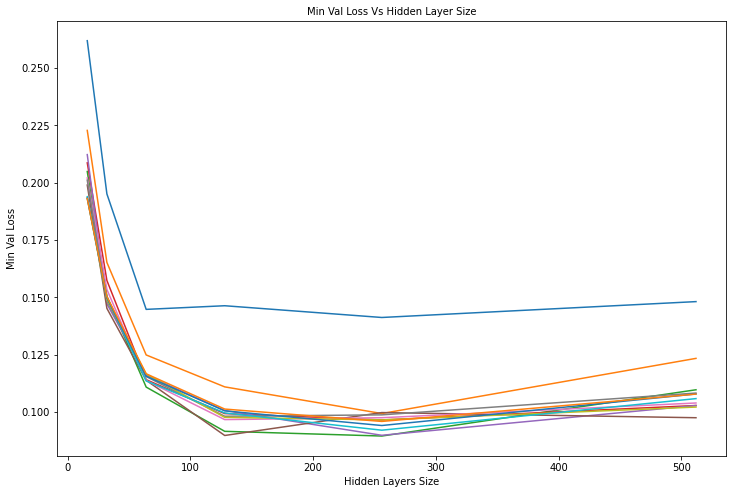

In [ ]:
lr_ = 0.01
N_EPOCHS = 12
N_hidden = [16,32,64,128,256,512]
res = []

for n in n_hidden: 
  print(" ")
  print(" N Hidden = ", n)
  network = NeuralNetwork([784,n,10])
  network.load_data(X_train, y_train, X_test, y_test,batch_size = 32 )
  loss = network.gradient_descent(lr = lr_ ,n_epochs = N_EPOCHS)
  # plot_summary( loss ,lr = lr_, str_="Loss")
  res.append(loss[1])

plt.figure(figsize = (12,8))
for i in range(len(n_hidden)):

  plt.plot(res[i],label = str(n_hidden[i]))
  plt.xlabel('iteration', fontsize=10)
  plt.ylabel('Val Loss', fontsize=10)

plt.legend()
plt.show()


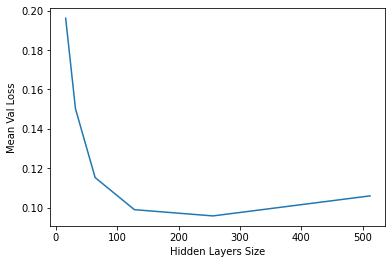

In [ ]:
N_hidden = [16,32,64,128,256,512]
plt.plot(N_hidden, np.mean(np.asarray(res)[:,6:], axis = 1))
plt.xlabel('Hidden Layers Size')
plt.ylabel('Mean Val Loss', fontsize=10)

plt.show()

In [ ]:
lr_ = 0.01
N_EPOCHS = 15
n_hidden = 128
Batch_size = 32

network = NeuralNetwork([784,n_hidden,10])
network.load_data(X_train, y_train, X_test, y_test,batch_size = Batch_size )
loss = network.gradient_descent(lr = lr_ ,n_epochs = N_EPOCHS)

0 --  LR: 0.01 TrainLoss: 0.11690672518993979  ValLoss: 0.14047552142850508  TrainAcc: 0.9652833333333334  ValAcc: 0.9605
1 --  LR: 0.008576958985908942 TrainLoss: 0.08785877738252043  ValLoss: 0.12917623682166704  TrainAcc: 0.9738833333333333  ValAcc: 0.965
2 --  LR: 0.007356422544596414 TrainLoss: 0.05621298757204634  ValLoss: 0.09995769330244568  TrainAcc: 0.9832666666666666  ValAcc: 0.9726
3 --  LR: 0.006309573444801933 TrainLoss: 0.050615493703147454  ValLoss: 0.11658486707187063  TrainAcc: 0.9852833333333333  ValAcc: 0.9732
4 --  LR: 0.005411695265464637 TrainLoss: 0.03615469059130025  ValLoss: 0.11719056539191582  TrainAcc: 0.9892  ValAcc: 0.973
5 --  LR: 0.004641588833612779 TrainLoss: 0.022501263046763687  ValLoss: 0.09948184300656532  TrainAcc: 0.99325  ValAcc: 0.9775
6 --  LR: 0.0039810717055349725 TrainLoss: 0.019916553922170715  ValLoss: 0.10883727816324168  TrainAcc: 0.9944666666666667  ValAcc: 0.9767
7 --  LR: 0.0034145488738336017 TrainLoss: 0.015346691803386232  ValLos